# Sarcasm_NLP

In [1]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from stop_words import get_stop_words # nltk doesnt work for me so we use this package
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
import eli5
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
#from eli5.lime import TextExplainer

In [2]:
import json
import pandas as pd
import numpy as np
import preprocessor as prepro
import tqdm 
import spacy 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier
import altair as alt 
import eli5
#from eli5.lime import TextExplainer
from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

C:\Users\Claude\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [121]:
import streamlit

In [3]:
data = [json.loads(line) for 
        line in open(r'D:\random_projets\sarcasm_nlp\Sarcasm_Headlines_Dataset.json', 'r')]

In [4]:
df = pd.DataFrame.from_dict(data) 
df.dtypes

article_link    object
headline        object
is_sarcastic     int64
dtype: object

In [5]:
df['headline'] = df['headline'].str.lower()
df = df.drop('article_link', axis=1) # drop this useless thing

In [6]:
print(df.sort_values(by="is_sarcastic", ascending=False).iloc[0:9,0]) # 10 sarcastics sentences

21954    area man's biggest accomplishment not ever kil...
10347    melania trump hosts state dinner in stunning b...
20977    opening soda bottle inadvertently makes man loser
10326    david blaine starves self of attention for 33 ...
10327      neighbor bragging about 20-pound box he fedexed
20976    family watches in silence as dad checks out wa...
20971    warning on police body camera footage cautions...
10335    woman going to take quick break after filling ...
10336    republicans give in right before obamacare wou...
Name: headline, dtype: object


<AxesSubplot: xlabel='is_sarcastic', ylabel='count'>

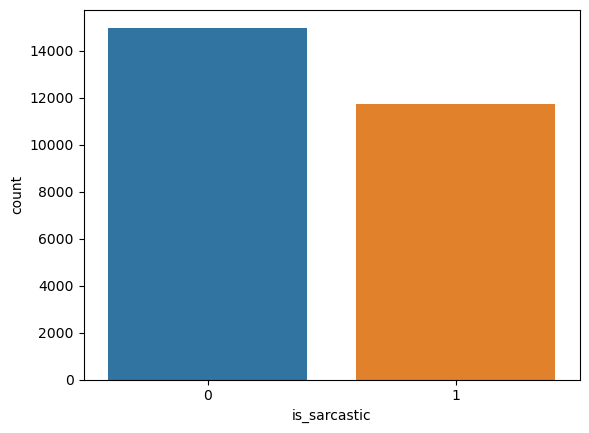

In [7]:
sns.countplot(x = df['is_sarcastic'])
# 0 stand for not sarcastic
# 1 stand for sarcastic 
# we have a balanced db

In [8]:
stop = get_stop_words('english')

In [11]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
df['headline_clean'] = df['headline'].str.replace(pat, '')
df['headline_clean'] = df['headline_clean'].str.replace(r'\s+', ' ')
df['headline_clean'] = df['headline_clean'].str.replace("'s", '')
df['headline_clean'] = df['headline_clean'].str.replace("'", '')
df['headline_clean'] = df['headline_clean'].str.replace("s", '')
df['headline_clean'] = df['headline_clean'].str.replace("u", '')

C:\Users\Claude\AppData\Local\Temp\ipykernel_13600\4033960418.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['headline_clean'] = df['headline'].str.replace(pat, '')
C:\Users\Claude\AppData\Local\Temp\ipykernel_13600\4033960418.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['headline_clean'] = df['headline_clean'].str.replace(r'\s+', ' ')


In [10]:
nlp = spacy.load('en_core_web_sm')

In [26]:
clean_text = []

pbar = tqdm.tqdm(total=len(df['headline_clean']),position=0, leave=True)
for text in nlp.pipe(df['headline_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████| 26709/26709 [00:20<00:00, 10960.14it/s]

In [48]:
def text_prepro(texts):
    texts_clean = texts.replace('#','').replace(r'\s+', ' ').replace("'s", '').replace("s", '').replace("u", '')

    clean_container = []

    pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

    for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

        txt = [token.lemma_.lower() for token in text 
               if token.is_alpha 
               and not token.is_stop 
               and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
    return clean_container

In [28]:
df2 = pd.DataFrame({'label':df['is_sarcastic'], 'text':df['headline_clean']})

In [30]:
df2.label.value_counts().reset_index()

,index,label
0,0,14985
1,1,11724


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df2['text'], df2['label'], test_size = 0.3, random_state = 42)

In [35]:
tfidf = TfidfVectorizer()
cls = LogisticRegression()
pipe = make_pipeline(tfidf, cls)

In [36]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [37]:
y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     10541
           1       0.91      0.82      0.86      8155

    accuracy                           0.88     18696
   macro avg       0.89      0.88      0.88     18696
weighted avg       0.89      0.88      0.88     18696



In [117]:
testii = ['Women deserve the right to vote for the next president of our nation']

In [118]:
testiii = text_prepro(pd.Series(testii))

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


In [119]:
testiii

['women deserve right vote president nation']

In [120]:
pipe.predict(testii) # this is the model we use to predict stuff

array([1], dtype=int64)

In [77]:
eli5.show_weights(pipe, top=10, target_names=['0','1'])

In [84]:
tokens = []

for text in nlp.pipe(df['headline_clean'], disable=["ner"]):
    proj_tok = [token.lemma_.lower() for token in text 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
    tokens.append(proj_tok)

In [85]:
df['tokens'] = tokens

In [86]:
data_sarcasm = df[df['is_sarcastic'] == 1]

In [88]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data_sarcasm['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data_sarcasm['tokens']]

In [89]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=10, workers = 4, passes=10)

In [90]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

C:\Users\Claude\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [91]:
pyLDAvis.display(lda_display)